<a href="https://colab.research.google.com/github/SantoshAhirrao/3D-House-Project/blob/master/Enron_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Colab Preparation

In [60]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [62]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [64]:
downloaded = drive.CreateFile({'id':'14eAfKEp3BY8p5tkqXXZBnoPzSLVo4AZx'}) # replace the id with id of file you want to access
downloaded.GetContentFile('emails.csv') 

Jupyter Notebook

Import Libs

In [65]:
import re
import os, sys, email
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
import wordcloud

# Network analysis
import networkx as nx

# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output
# print(check_output(["ls", r"D:/BeCode/KPMG - Enron/Preparation/emails.csv"]).decode("utf8"))

In [7]:
pd.set_option('display.max_columns', None)   # To see all the columns of data frame

### 1. Loading and cleaning data

In [66]:
# Read the data into a DataFrame
emails_df = pd.read_csv(r'emails.csv')
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [67]:
# A single message looks like this
print(emails_df['message'][5])

Message-ID: <30965995.1075863688265.JavaMail.evans@thyme>
Date: Thu, 31 Aug 2000 04:17:00 -0700 (PDT)
From: phillip.allen@enron.com
To: greg.piper@enron.com
Subject: Re: Hello
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Greg Piper
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Greg,

 How about either next Tuesday or Thursday?

Phillip


In [20]:
emails_df.shape

(517401, 2)

In [69]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [70]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)

# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
    
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))

# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages
emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [71]:
emails_df.head(1)

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p


Saving it to the processed data

In [2]:
emails_df.to_csv('processed_data.csv')

NameError: ignored

In [1]:
from google.colab import files
files.download('processed_data.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Email Network Analysis

In [75]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import wordcloud

Get the processed file in the colab
downloaded = drive.CreateFile({'id':'1R9vW5dmox7i8OGOoDql_r9yUrvAJgvhD'}) # replace the id with id of file you want to access
downloaded.GetContentFile('resources.csv') 

In [76]:
emails_df.describe(include='all')

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
count,517401,517401,517401,517401,495554,517401,517372,517372,517372,517372,517372,517372,517372,517372,517372,517372,517401,517401
unique,517401,517401,224128,20328,54748,159290,1,2,3,27980,73552,33701,132,5335,259,429,249025,150
top,delainey-d/sent/372.,<32481174.1075842110540.JavaMail.evans@thyme>,"Wed, 27 Jun 2001 16:02:00 -0700 (PDT)",(kay.mann@enron.com),(pete.davis@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Kay Mann,,,,\Kay_Mann_June2001_1\Notes Folders\All documents,Kaminski-V,vkamins.nsf,"As you know, Enron Net Works (ENW) and Enron G...",kaminski-v
freq,1,1,1118,16735,9155,19187,517372,479286,494971,16324,9124,388486,517197,6639,26995,24029,112,28465


In [77]:
columns = emails_df.columns

for column in columns:
  print("{} - {}".format(column,emails_df[column].nunique()))

file - 517401
Message-ID - 517401
Date - 224128
From - 20328
To - 54748
Subject - 159290
Mime-Version - 1
Content-Type - 2
Content-Transfer-Encoding - 3
X-From - 27980
X-To - 73552
X-cc - 33701
X-bcc - 132
X-Folder - 5335
X-Origin - 259
X-FileName - 429
content - 249025
user - 150


In [18]:
emails_df.columns


Index(['file', 'Message-ID', 'Date', 'From', 'To', 'Subject', 'Mime-Version',
       'Content-Type', 'Content-Transfer-Encoding', 'X-From', 'X-To', 'X-cc',
       'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName', 'content', 'user'],
      dtype='object')

In [78]:
emails_df.dtypes

file                         object
Message-ID                   object
Date                         object
From                         object
To                           object
Subject                      object
Mime-Version                 object
Content-Type                 object
Content-Transfer-Encoding    object
X-From                       object
X-To                         object
X-cc                         object
X-bcc                        object
X-Folder                     object
X-Origin                     object
X-FileName                   object
content                      object
user                         object
dtype: object

In [79]:
emails_df.iloc[0]['To']

frozenset({'tim.belden@enron.com'})


# Defining Cleanup function

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
stop = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent","Re", "Fw", "fw","re"))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
def clean(document):
  doc1 = document.rstrip()
  doc2 = re.sub(r'[^a-zA-Z]', ' ', doc1)
  doc3 = " ".join([i for i in doc2.lower().split() if i not in stop])
  doc4 = ''.join(ch for ch in doc3 if ch not in exclude)
  doc5 = re.sub(r"\b[a-zA-Z]\b", "", doc4)
  doc6 = " ".join(lemma.lemmatize(word) for word in doc5.split())

  return doc6

In [23]:
doc = emails_df.iloc[10]['content']

In [24]:
clean(doc)

'mr buckner delivered gas behind san diego enron energy service appropriate enron entity forwarded request zarin imam ee phone number phillip allen'

Top 10 users

In [53]:
users = emails_df['user'].unique()

In [54]:
print("Total count of users: {}".format(len(users)))


Total count of users: 150


In [57]:
top_users = emails_df.groupby('user').count()['file'].sort_values(ascending=False)[:10]

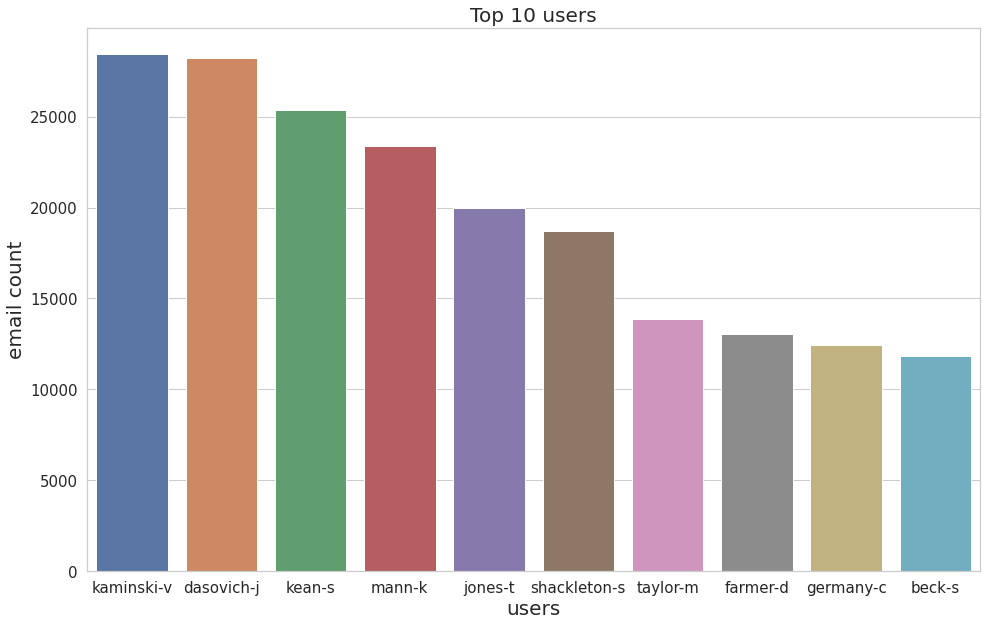

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

ax = sns.barplot(x=top_users.index , y=top_users)
ax.axes.set_title("Top 10 users",fontsize=20)
ax.set_xlabel("users",fontsize=20)
ax.set_ylabel("email count",fontsize=20)

sns.set(style="whitegrid")
ax.tick_params(labelsize=15)
plt.savefig('/content/drive/My Drive/top10.png')
plt.show()

Top 10 email senders

In [61]:
top_senders = emails_df.groupby('From').count()['file'].sort_values(ascending=False)[:10]

In [30]:
emails_df['Date'] = pd.to_datetime(emails_df['Date'], utc=True)
#emails_df['Date'] = pd.to_datetime(emails_df['Date'] ,errors = 'coerce', format = '%Y-%m-%dT%H:%M:%S.%f%z', infer_datetime_format = True, cache = True)

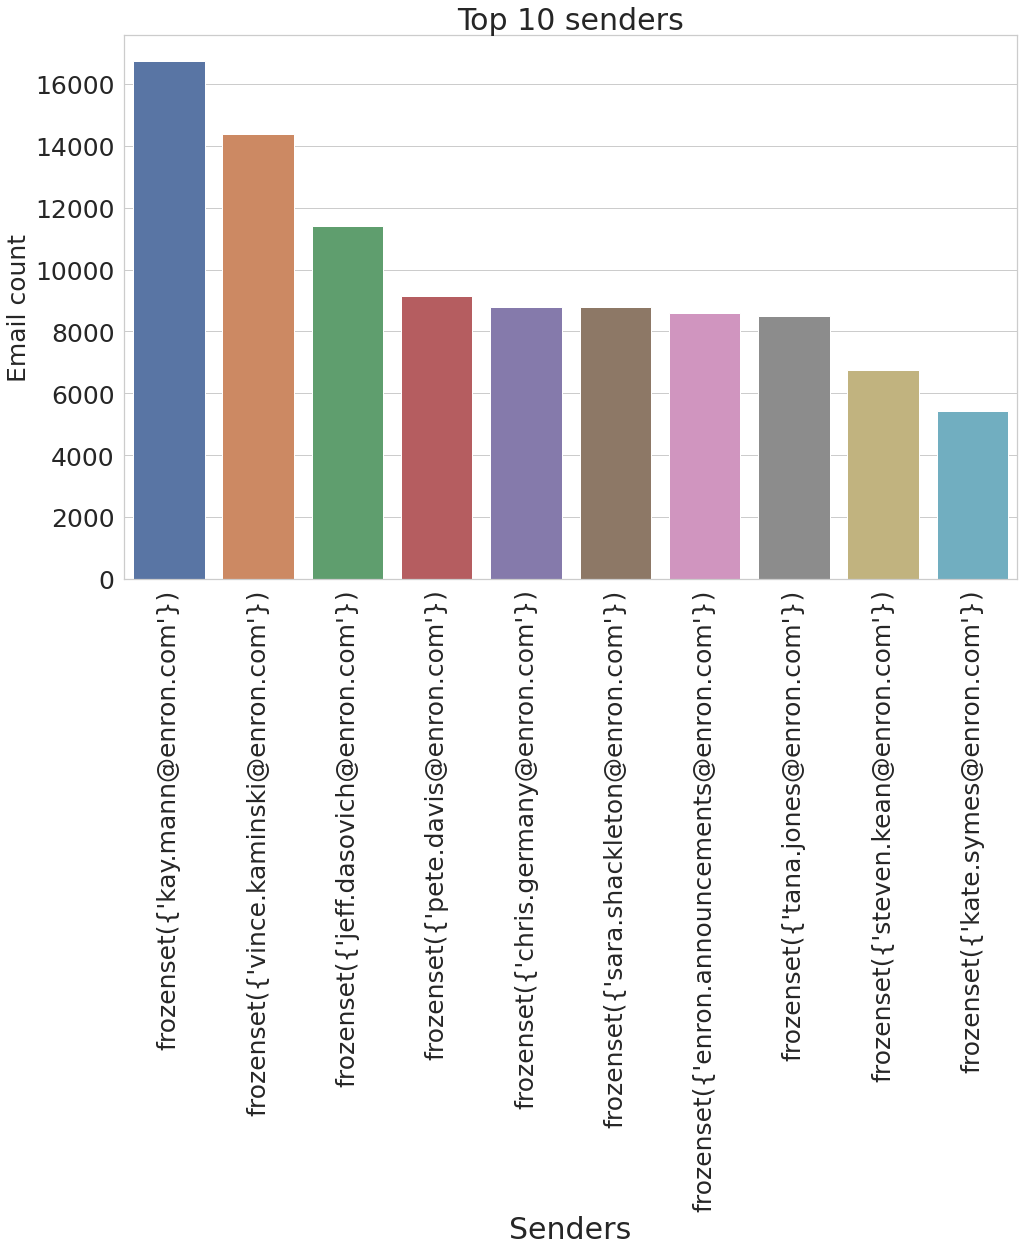

In [65]:
plt.figure(figsize=(16, 10))

ax = sns.barplot(x=top_senders.index , y=top_senders)
ax.axes.set_title("Top 10 senders",fontsize=30)
ax.set_xlabel("Senders",fontsize=30)
ax.set_ylabel("Email count",fontsize=25)

sns.set(style="whitegrid")
ax.tick_params(axis = 'x', labelsize=25, labelrotation = 90)
ax.tick_params(axis = 'y', labelsize=25)
plt.savefig('/content/drive/My Drive/top10senders.png')
plt.show()


# Top 10 email receivers

In [68]:
top_receivers = emails_df.groupby('To').count()['file'].sort_values(ascending=False)[:10]

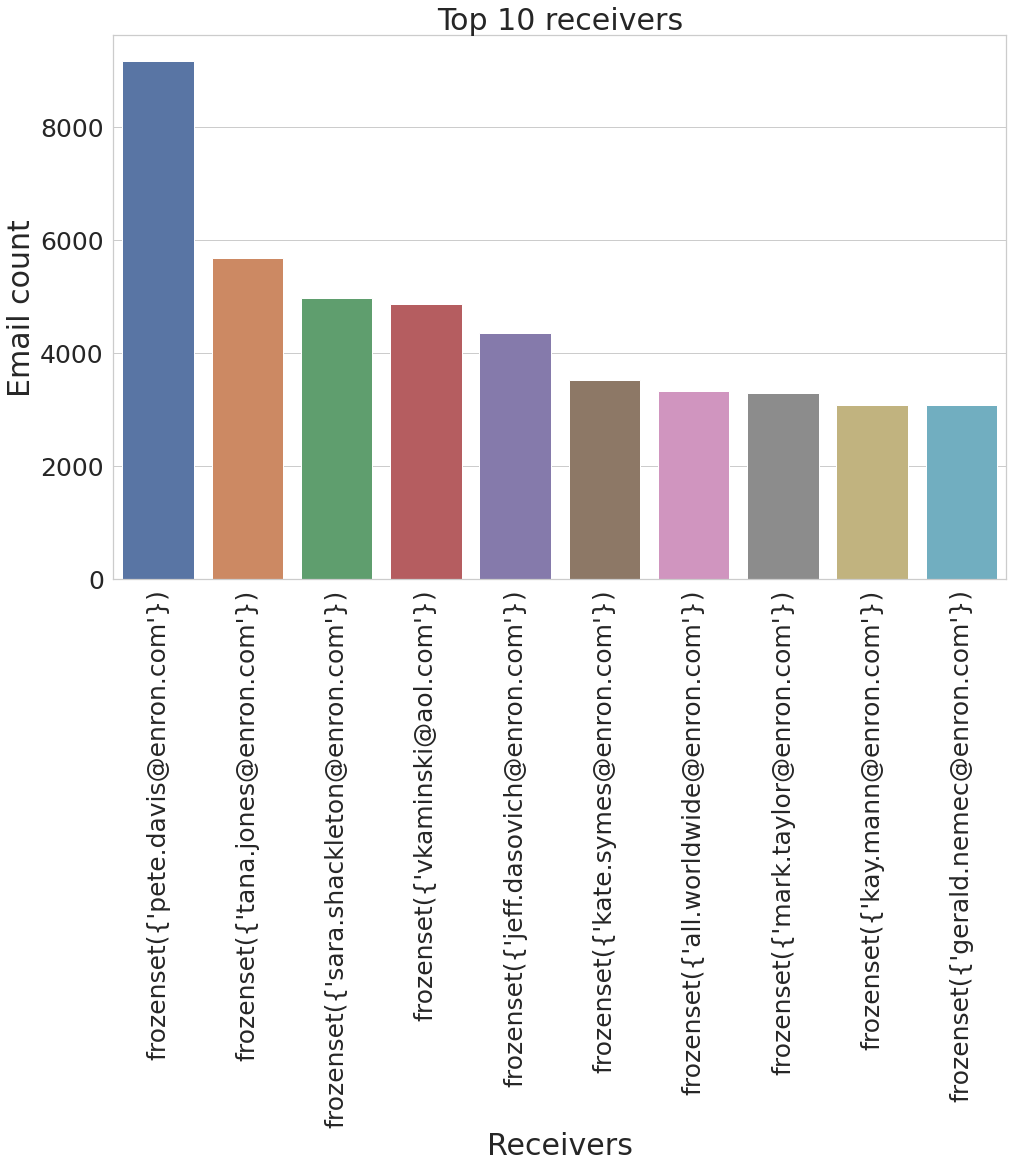

In [73]:
plt.figure(figsize=(16, 10))

ax = sns.barplot(x=top_receivers.index , y=top_receivers)
ax.axes.set_title("Top 10 receivers",fontsize=30)
ax.set_xlabel("Receivers",fontsize=30)
ax.set_ylabel("Email count",fontsize=30)

sns.set(style="whitegrid")
ax.tick_params(axis = 'x', labelsize=25, labelrotation = 90)
ax.tick_params(axis = 'y', labelsize=25)
plt.savefig('/content/drive/My Drive/top10receivers.png')
plt.show()

# Top 10 most frequent conversation

In [74]:
TestFrame2 = emails_df[['From', 'To', 'Date']].dropna()
TestFrame2 = TestFrame2.groupby(['From', 'To']).count().reset_index()
# rename column
TestFrame2.rename(columns={'Date': 'count'}, inplace=True)
print(TestFrame2.sort_values(by=['count'], ascending=False)[:10])

                                  From                            To  count
18151           (pete.davis@enron.com)        (pete.davis@enron.com)   9141
69039       (vince.kaminski@enron.com)           (vkaminski@aol.com)   4308
46010  (enron.announcements@enron.com)     (all.worldwide@enron.com)   2206
45998  (enron.announcements@enron.com)       (all.houston@enron.com)   1701
35593             (kay.mann@enron.com)     (suzanne.adams@enron.com)   1528
69033       (vince.kaminski@enron.com)  (shirley.crenshaw@enron.com)   1190
29443          (steven.kean@enron.com)  (maureen.mcvicker@enron.com)   1014
35001             (kay.mann@enron.com)              (nmann@erac.com)    980
90024           (kate.symes@enron.com)    (evelyn.metoyer@enron.com)    915
90031           (kate.symes@enron.com)    (kerri.thompson@enron.com)    859


# Splitting emails by year

# Word Cloud For Email Subject

(-0.5, 799.5, 599.5, -0.5)

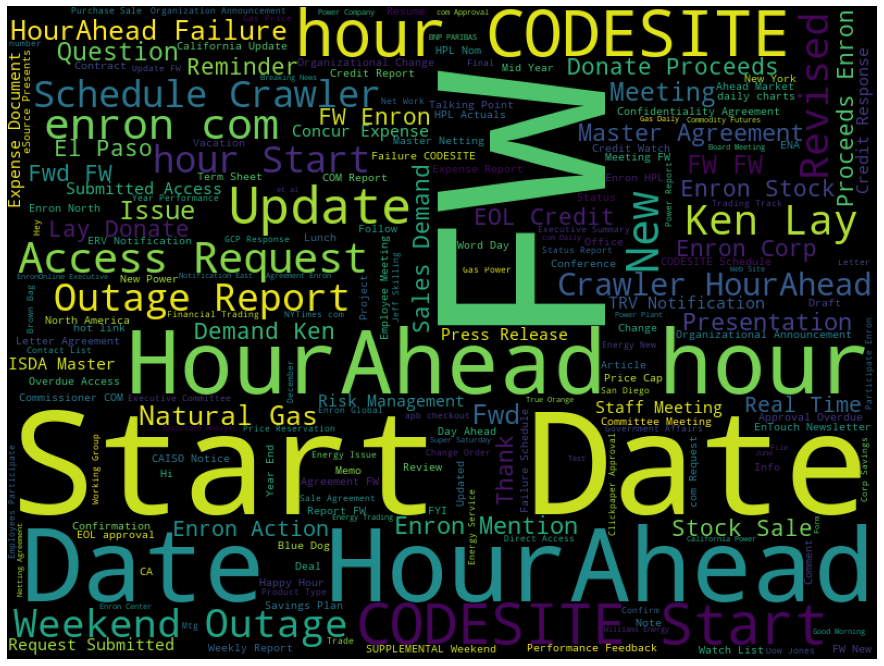

In [25]:
subjects = ' '.join(map(str, emails_df['Subject'].dropna()))
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")



# Word Cloud for Email Content

(-0.5, 799.5, 599.5, -0.5)

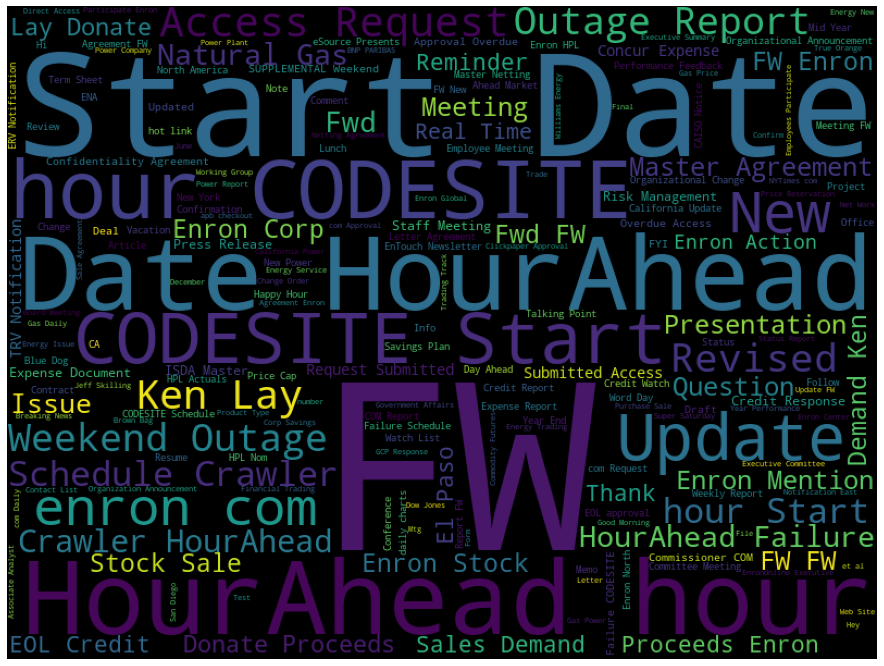

In [26]:
content = ' '.join(map(str, emails_df['content']))
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")

# Update the stop word and check Again

(-0.5, 799.5, 599.5, -0.5)

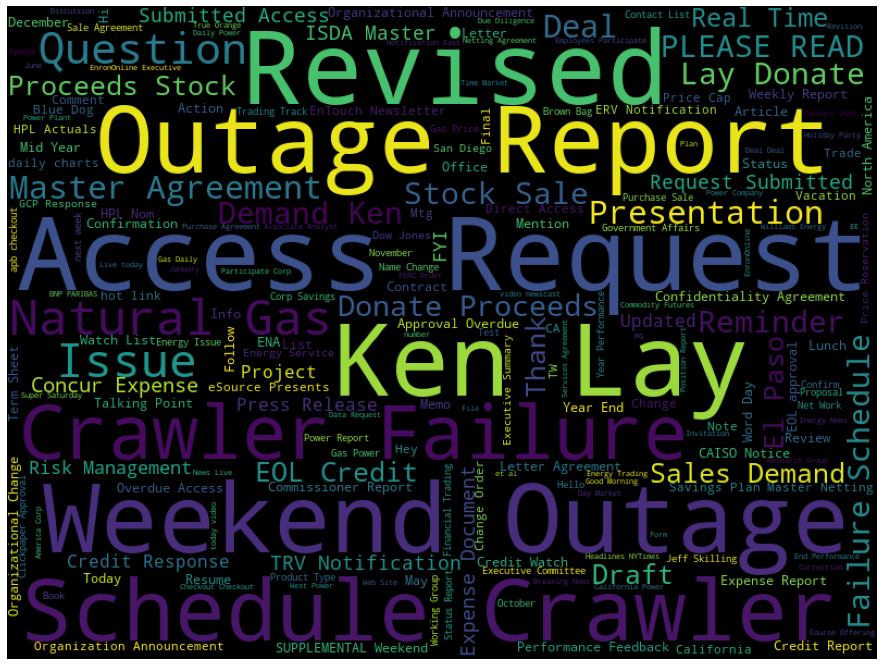

In [27]:
# Uodate the stop word and check again

subjects = ' '.join(map(str, emails_df['Subject'].dropna()))
fig, ax = plt.subplots(figsize=(16, 12))

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','FW','Date','Update','CODESITE','New','Fwd','meeting','Start','Date','Hour','Ahead','Start','enron','com','hour','HourAhead','Conference Call','Conference', 'Call'])

wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=stop_words).generate(subjects)
ax.imshow(wc)
ax.axis("off")


(-0.5, 799.5, 599.5, -0.5)

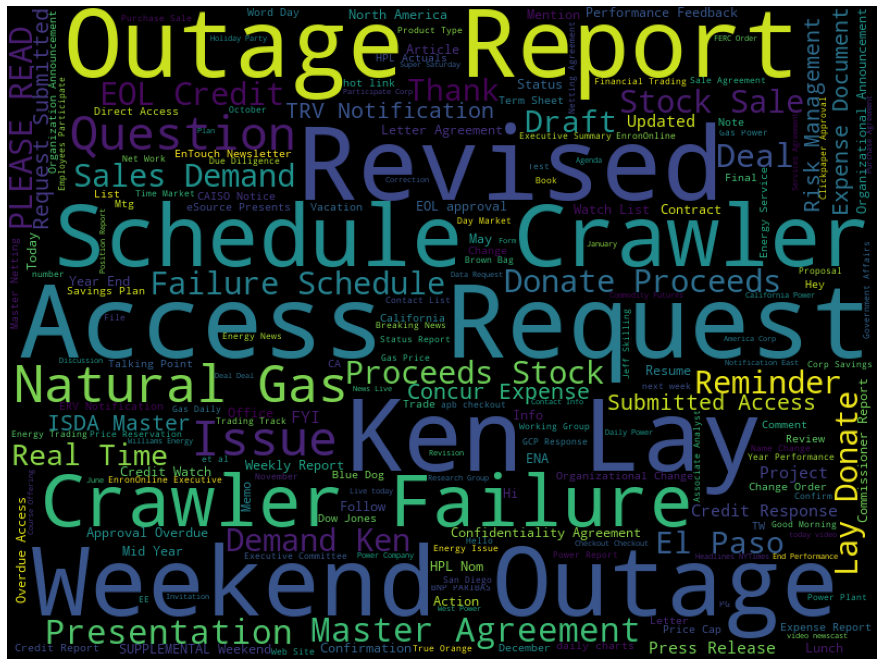

In [28]:
# Word count dated for Content

content = ' '.join(map(str, emails_df['content']))
fig, ax = plt.subplots(figsize=(16, 12))

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','FW','Date','Update','CODESITE','New','Fwd','meeting','Start','Date','Hour','Ahead','Start','enron','com','hour','HourAhead','Conference Call','Conference', 'Call'])

wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=stop_words).generate(subjects)
ax.imshow(wc)
ax.axis("off")

# Top 10 who received mails from outside of Enron

In [44]:
emails_df[["To","Date","From"]]

,To,Date,From
0,(tim.belden@enron.com),"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com)
1,(john.lavorato@enron.com),"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com)
2,(leah.arsdall@enron.com),"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com)
3,(randall.gay@enron.com),"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com)
4,(greg.piper@enron.com),"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com)
...,...,...,...
517396,(kori.loibl@enron.com),"Wed, 28 Nov 2001 13:30:11 -0800 (PST)",(john.zufferli@enron.com)
517397,(john.lavorato@enron.com),"Wed, 28 Nov 2001 12:47:48 -0800 (PST)",(john.zufferli@enron.com)
517398,(dawn.doucet@enron.com),"Wed, 28 Nov 2001 07:20:00 -0800 (PST)",(john.zufferli@enron.com)
517399,(jeanie.slone@enron.com),"Tue, 27 Nov 2001 11:52:45 -0800 (PST)",(john.zufferli@enron.com)


In [56]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   file                       517401 non-null  object
 1   Message-ID                 517401 non-null  object
 2   Date                       517401 non-null  object
 3   From                       517401 non-null  object
 4   To                         495554 non-null  object
 5   Subject                    517401 non-null  object
 6   Mime-Version               517372 non-null  object
 7   Content-Type               517372 non-null  object
 8   Content-Transfer-Encoding  517372 non-null  object
 9   X-From                     517372 non-null  object
 10  X-To                       517372 non-null  object
 11  X-cc                       517372 non-null  object
 12  X-bcc                      517372 non-null  object
 13  X-Folder                   517372 non-null  

In [54]:
def listifyString(element):
  return element.strip('][\'').split(',')

In [59]:
emails_df["To","From"].astype(str)

KeyError: ignored

In [52]:
ftd = dataset[['From', 'To', 'Date']].dropna()
ftd = ftd.loc[ftd['To'].map(listifyString).map(len) == 1]
ftd = ftd.loc[ftd['To'] != ftd['From']]
ftd = ftd.groupby(['From', 'To']).count().reset_index()

# rename column
ftd.rename(columns={'Date': 'count'}, inplace=True)
ftd.sort_values('count', ascending=False).head(10)

NameError: ignored

In [ ]:
df[[~df.iloc[i,:].str.contains('String_to_match').any()  for i in range(0,len(df))]]

In [39]:
def listifyString(element):
  return element.str.strip('][\'').split(',')

def fromOutsideEnron(element):
  return element[0].endswith('@enron.com')

In [40]:
sub_df = emails_df[['From', 'To']].dropna()
sub_df = sub_df[~sub_df['From'].map(listifyString).map(fromOutsideEnron)]

sub_df = sub_df.loc[sub_df['To'].map(listifyString).map(len) == 1]

sub_df = sub_df.groupby(['To']).count().reset_index()

sub_df.rename(columns={'From': 'count'}, inplace=True)
td = sub_df.sort_values('count', ascending=False).head(10)

AttributeError: ignored

In [33]:
#td = sub_df.['filename'].sort_values(ascending=False)[:10]#sort_values('count', ascending=False).head(10)
plt.figure(figsize=(16, 10))

ax = sns.barplot(x=td['To'] , y=td['count'], palette="Blues_d")
ax.axes.set_title("Top 10 receivers receiving email from outside Enron",fontsize=30)
ax.set_xlabel("Receivers",fontsize=30)
ax.set_ylabel("Email count",fontsize=30)

sns.set(style="whitegrid")
ax.tick_params(axis = 'x', labelsize=25, labelrotation = 90)
ax.tick_params(axis = 'y', labelsize=25)
plt.savefig('/content/drive/My Drive/ALDA-Project/top10receiversfromoutside.png')
plt.show()

NameError: ignored

<Figure size 1152x720 with 0 Axes>